In [2]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import yolov5
import os
import easyocr
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model_license_plate = yolov5.load('keremberke/yolov5m-license-plate')
model_license_plate.conf = 0.25  # 신뢰도 기준 25%이상
model_license_plate.iou = 0.45  # 박스 겹침 정도, 45%이상 겹치는 박스 중복탐지로 제거
model_license_plate.agnostic = False  # 객체 종류별로 중복을 처리
model_license_plate.multi_label = False  # 하나의 객체에 여러 라벨 붙는 경우를 방지
model_license_plate.max_det = 1000  # 한이미지당 최대 탐지 객체 수 1000개
model_license_plate.to(device)

YOLOv5  2025-1-14 Python-3.11.11 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

In [9]:
folder_path = './github/iamges/'

# 폴더 내 모든 파일 리스트 가져오기
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

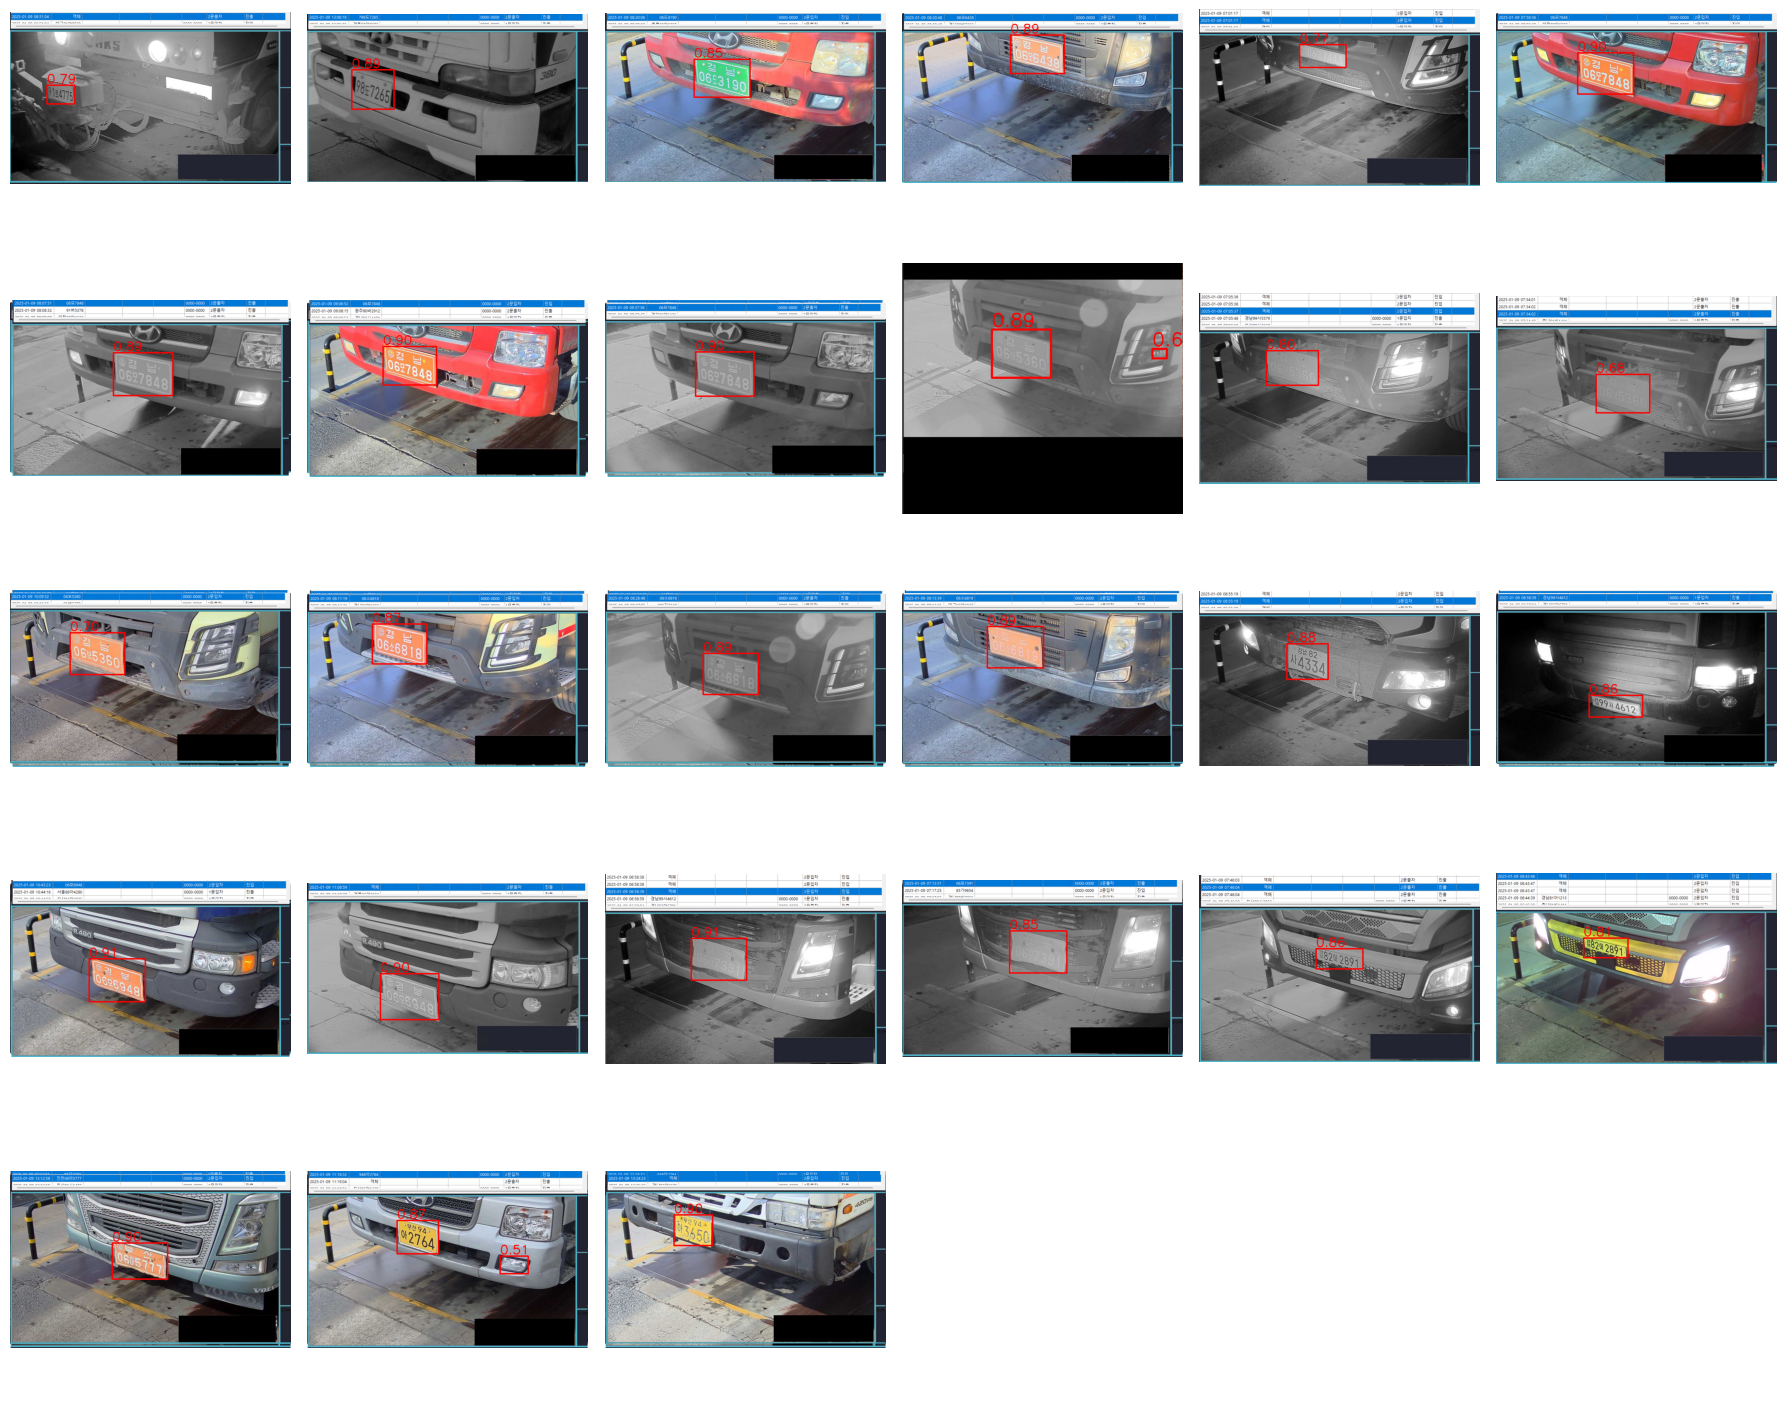

In [12]:
%matplotlib inline
# 예시 이미지 경로 설정
image_count = 27
rows = 5
cols = 6

# 서브플롯 설정
fig, axes = plt.subplots(rows, cols, figsize=(18, 15)) 
reader = easyocr.Reader(['en', 'ko'], gpu=True)
for i, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)
    
    # 모델로 이미지에서 번호판 감지
    results = model_license_plate(img_path)

    # 바운딩 박스 정보 추출
    boxes = results.xywh[0][:, :4].cpu().numpy()  # 바운딩 박스 좌표
    labels = results.xywh[0][:, 5].cpu().numpy()  # 감지된 클래스 (번호판의 경우 class 0)
    confidences = results.xywh[0][:, 4].cpu().numpy()  # 신뢰도

    # 이미지를 읽어서 OpenCV로 처리
    img = cv2.imread(img_path)

    # 바운딩 박스 그리기 (번호판에만)
    for j, box in enumerate(boxes):
        if labels[j] == 0:  
            x_center, y_center, width, height = box
            x1 = int((x_center - width / 2))
            y1 = int((y_center - height / 2))
            x2 = int((x_center + width / 2))
            y2 = int((y_center + height / 2))
            license_plate_roi = img[y1:y2, x1:x2]
            results = reader.readtext(license_plate_roi)

            # cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)  # 진한 빨간색 (BGR 형식)
            # confidence_text = f'{confidences[j]:.2f}'  # 신뢰도 소수점 두 자리로 표시
            # cv2.putText(img, confidence_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)

            if results :
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)  # 진한 빨간색 (BGR 형식)
                confidence_text = f'{confidences[j]:.2f}'  # 신뢰도 소수점 두 자리로 표시
                cv2.putText(img, confidence_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)

    # 이미지를 RGB로 변환하여 matplotlib에서 표시
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 서브플롯에 이미지 표시
    ax = axes[i // cols, i % cols]
    ax.imshow(img_rgb)  # 변경된 이미지를 표시
    ax.axis('off')  # 축 숨기기

# 서브플롯에 빈 축 숨기기
for j in range(i + 1, rows * cols):
    axes[j // cols, j % cols].axis('off')

plt.tight_layout()  # 서브플롯 간격 자동 조정
plt.show()